Pobierz dane

In [20]:
import os
import wfdb

# Ścieżka do katalogu z bazą
path = '../data/raw/'
data_dirs = ['afdb/',
            'mit-bih-arrhythmia-database/',
            'af-termination-challenge/',
            'fantasia/']

database_names = ['afdb', 'mitdb', 'aftdb', 'fantasia']

for i in range(len(data_dirs)):
    data_dir = path + data_dirs[i]
    database_name = database_names[i]
    # Sprawdź, czy baza danych jest już pobrana
    if not os.path.exists(data_dir) or len(os.listdir(data_dir)) == 0:
        print(f"Baza danych {database_name} nie jest pobrana. Pobieranie...")
        os.makedirs(data_dir, exist_ok=True)
        wfdb.dl_database(database_name, dl_dir=data_dir)
        print(f"Baza danych {database_name} została pobrana.")
    else:
        print(f"Baza danych {database_name} już istnieje w podanej lokalizacji.")

Baza danych afdb już istnieje w podanej lokalizacji.
Baza danych mitdb już istnieje w podanej lokalizacji.
Baza danych aftdb już istnieje w podanej lokalizacji.
Baza danych fantasia już istnieje w podanej lokalizacji.


Wyświelt próbkę

In [68]:
import matplotlib.pyplot as plt
data_dir = '2017_challenge/'
# Wczytaj rekord z MIT-BIH Arrhythmia Database (np. rekord 100)
record = wfdb.rdrecord(path + data_dir + 'data_10_1')  # Zastąp ścieżką do lokalnego pliku

# Wczytaj adnotacje
annotation = wfdb.rdann(path + data_dir + 'data_10_1', 'atr')  # Adnotacje dla rekordu 100

# Wyświetl podstawowe informacje o sygnale
print("Informacje o sygnale:")
print(f"Częstotliwość próbkowania: {record.fs} Hz")
print(f"Czas trwania sygnału: {record.sig_len / record.fs} s")
print(f"Liczba kanałów: {record.n_sig}")

# Wykres sygnału EKG (pierwsze 10 sekund)
time = [i / record.fs for i in range(record.sig_len)]  # Oś czasu
plt.figure(figsize=(10, 4))
plt.plot(time[:2000], record.p_signal[:2000, 0], label="Kanał 1")  # Pierwszy kanał0
plt.plot(time[:2000], record.p_signal[:2000, 1], label="Kanał 2")  # Drugi kanał0
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Sygnał EKG (10 sekund)')
plt.legend()
plt.show()

# Wyświetl adnotacje (typ arytmii i pozycje w czasie)
print("\nAdnotacje:")
for idx, sample in enumerate(annotation.sample[:14]):  # Przykładowe pierwsze 10 adnotacji
    time_sec = sample / record.fs
    label = annotation.aux_note[idx]
    print(f"Czas: {time_sec:.2f}s, Typ arytmii: {label}")


KeyboardInterrupt: 

Wyświetl otoczenie migotania

start:0    end: 110368


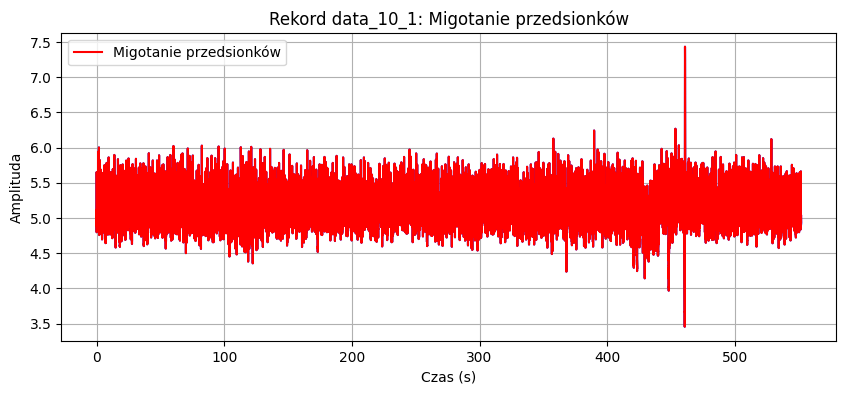

start:0    end: 570195


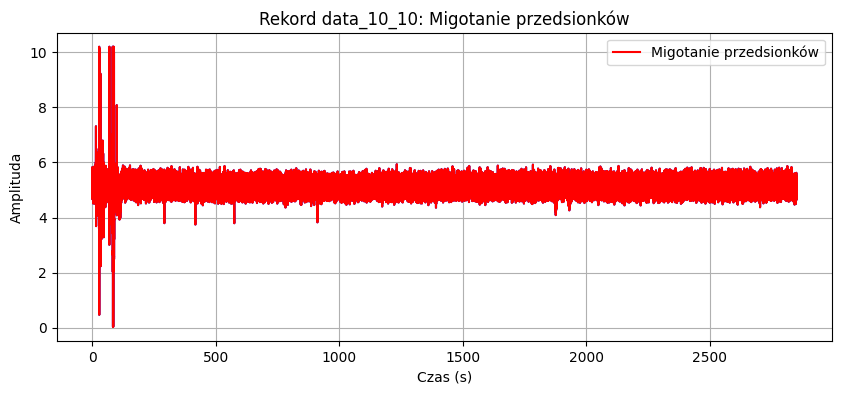

start:0    end: 129094


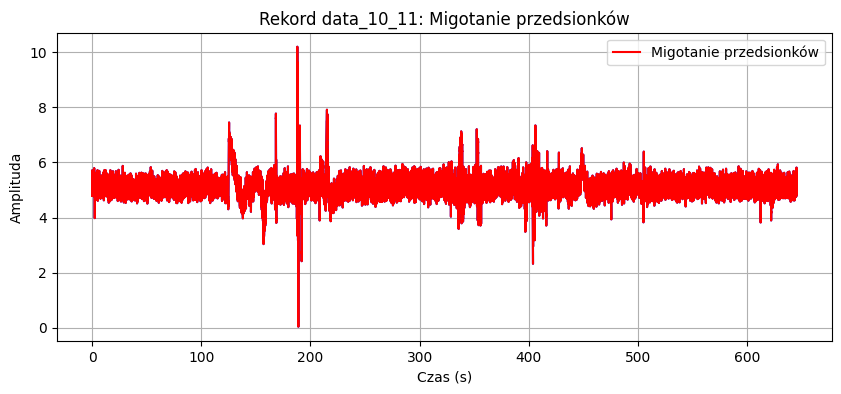

start:0    end: 99624


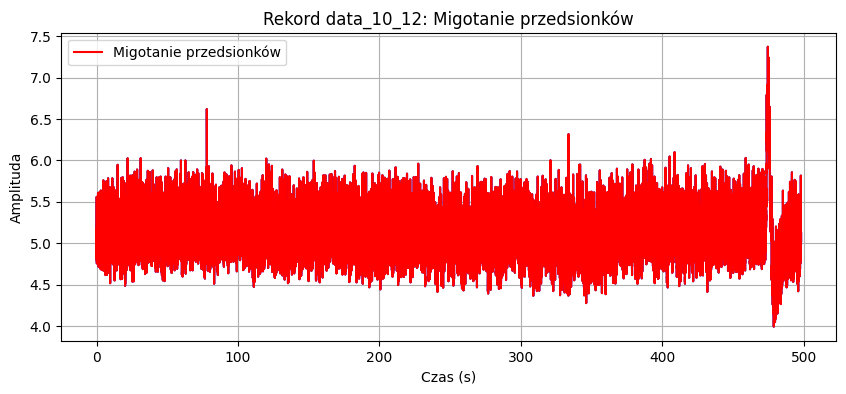

start:0    end: 133842


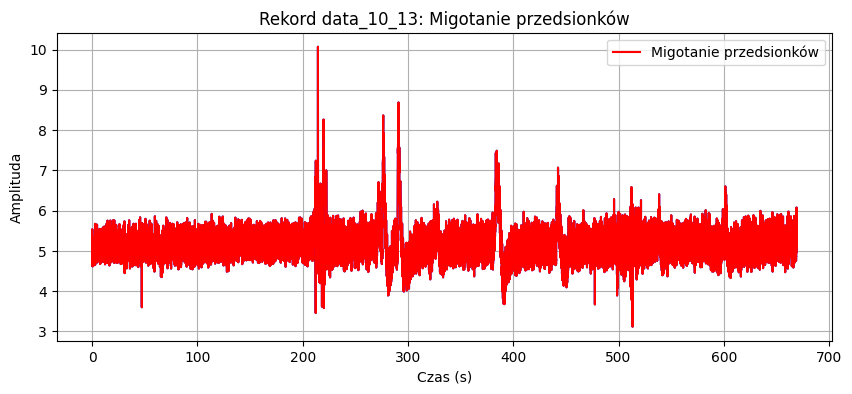

start:0    end: 44775


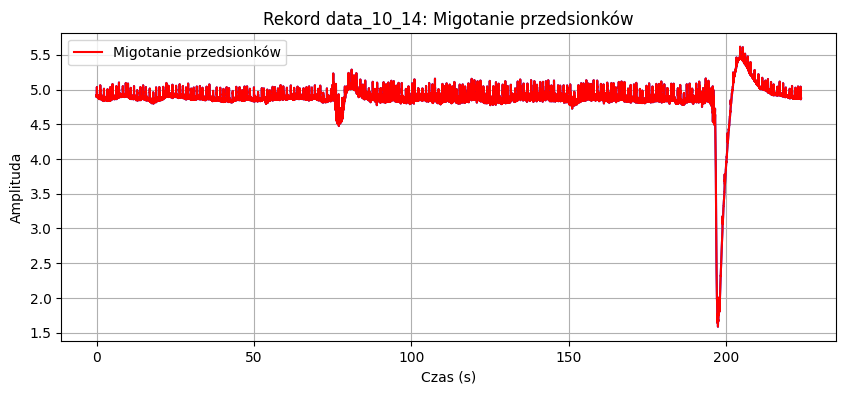

start:0    end: 143155


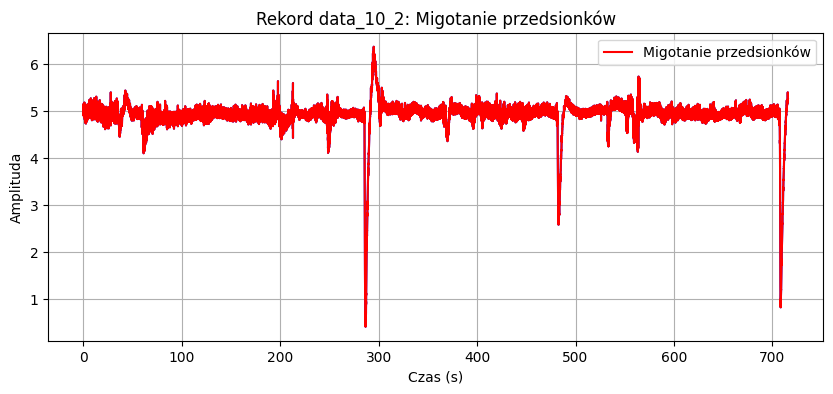

start:0    end: 99130


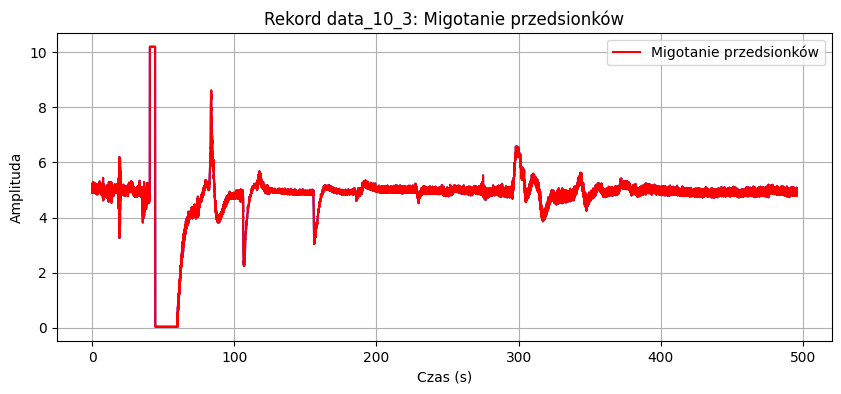

start:0    end: 149962


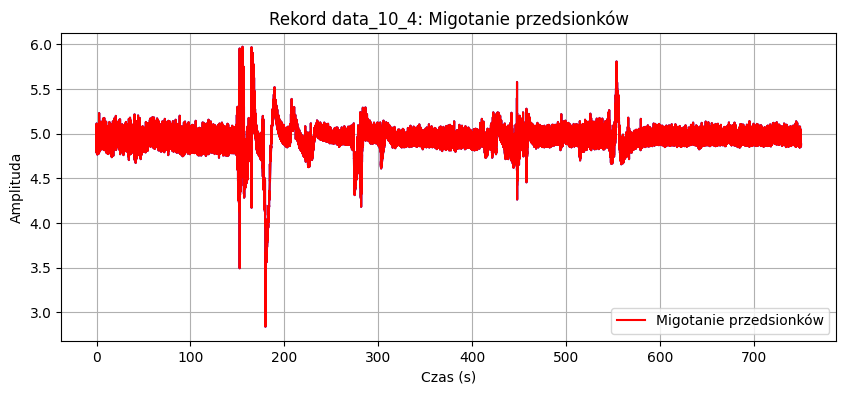

start:0    end: 151988


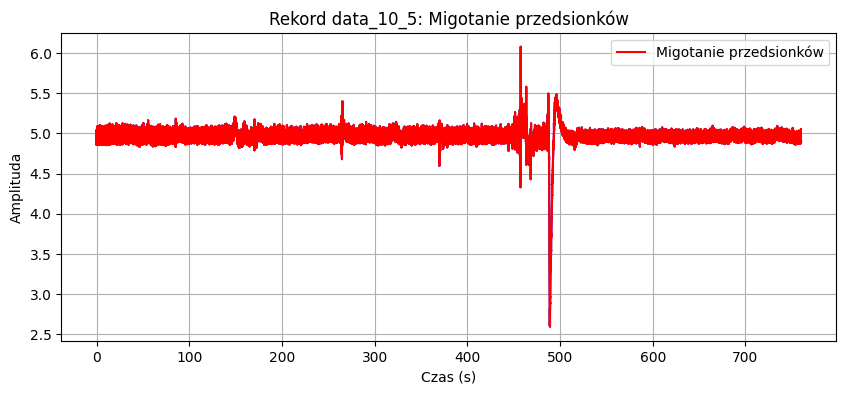

start:0    end: 305652


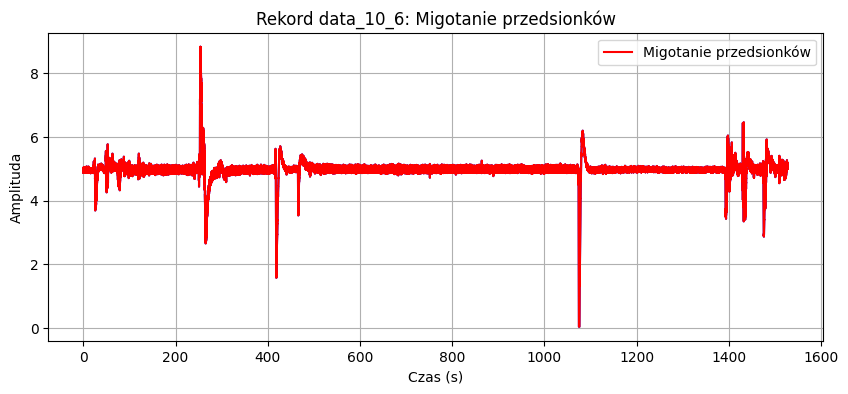

start:0    end: 150006


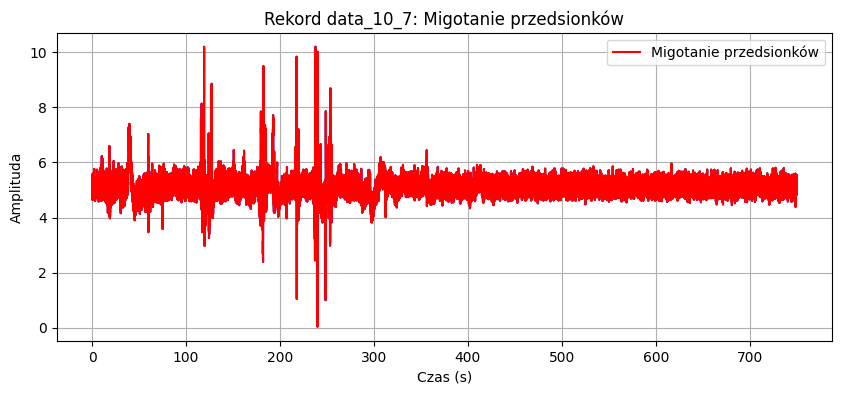

start:0    end: 656008


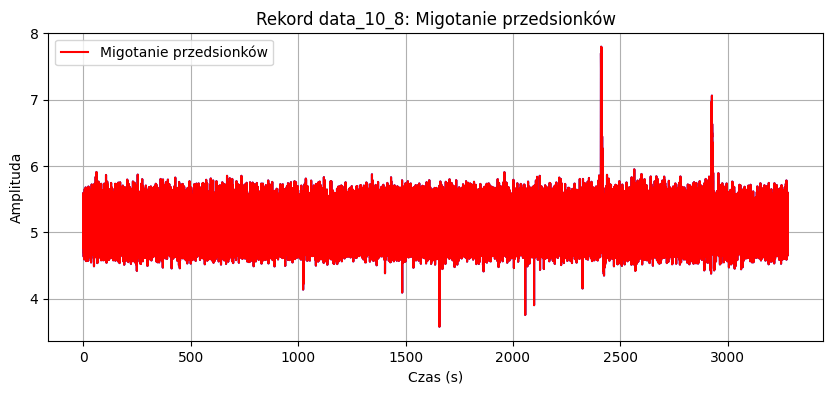

start:0    end: 70326


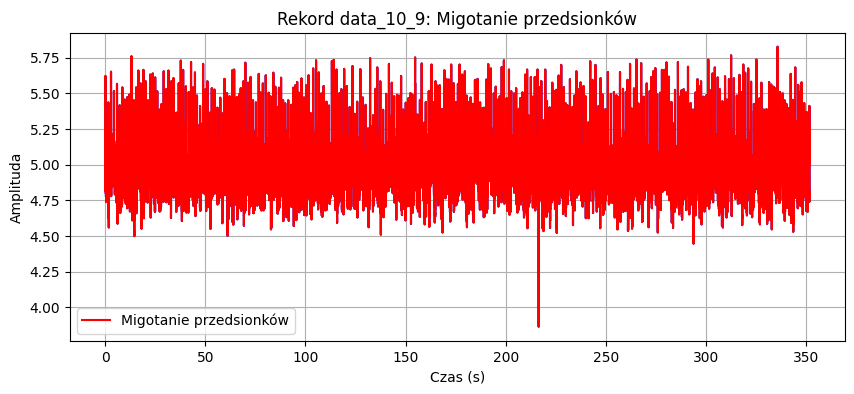

start:0    end: 4530304


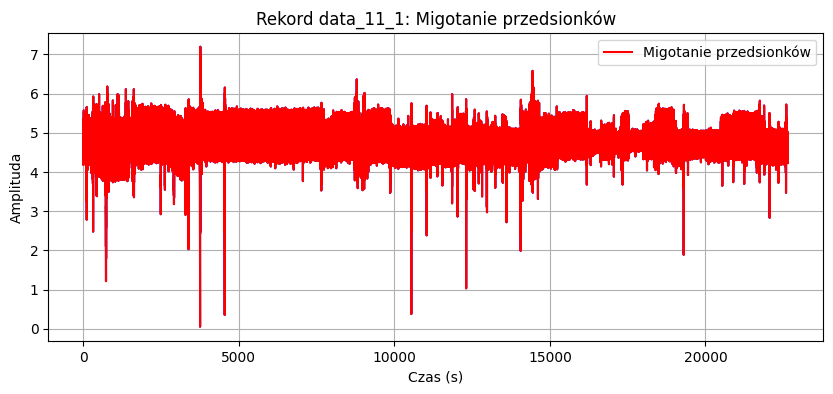

start:0    end: 1254162


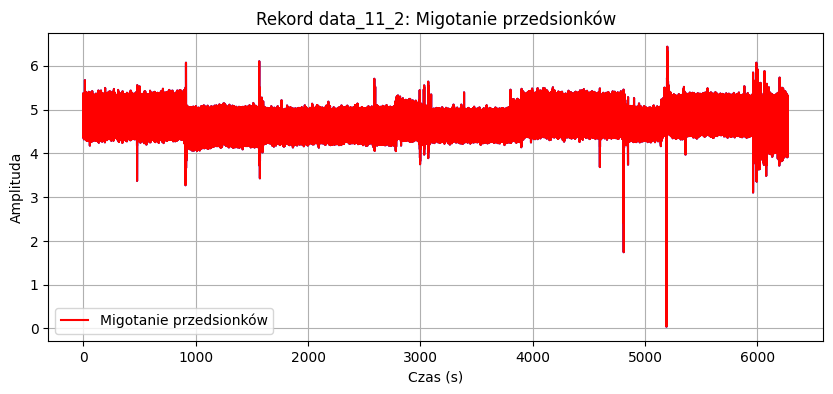

start:0    end: 1142644


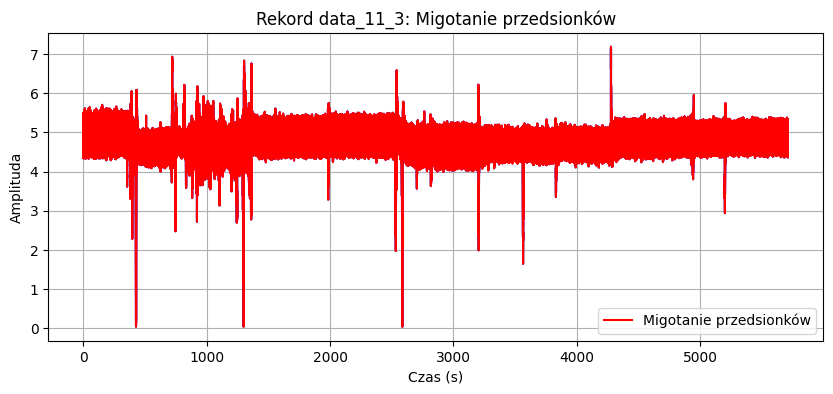

start:0    end: 825888


KeyboardInterrupt: 

In [64]:
import numpy as np
context_window = 720  # liczba próbek do pokazania przed i po zaznaczonym obszarze
data_dir = '2017_challenge/'

# Przechodzenie przez pliki w katalogu
for record_file in os.listdir(path + data_dir):
    if record_file.endswith('.dat'):  # Upewnij się, że to plik .dat

        # Ustal nazwę rekordu bez rozszerzenia
        record_name = record_file[:-4]

        # Wczytaj rekord i adnotacje
        record = wfdb.rdrecord(os.path.join(path + data_dir, record_name))
        sampling_rate = record.fs  # częstość próbkowania w Hz

        annotation = wfdb.rdann(os.path.join(path + data_dir, record_name), 'atr')

        # Znajdź indeksy adnotacji
        bracket_start_indices = [i for i, sym in enumerate(annotation.symbol) if sym == '+']

        for i, idx in enumerate(bracket_start_indices):
            if 'AFIB' in annotation.aux_note[idx]:
                 start_idx = idx
            else:
                continue
            if i < len(bracket_start_indices)-1:#jeżeli sygnał kończy się AFIB to end_idx to koniec sygnału
                end_idx = bracket_start_indices[i+1]
            else:
                end_idx = -1
                
            # Indeksy próbek sygnału
            start_sample = annotation.sample[start_idx]
            end_sample = annotation.sample[end_idx]


            # Ustal indeksy próbek z dodatkowymi marginesami przed i po obszarze zaznaczonym
            plot_start = max(0, start_sample - context_window)
            plot_end = min(len(record.p_signal), end_sample + context_window)
            print(f"start:{start_sample}    end: {end_sample}")
            # Wyciągnij fragment sygnału EKG do wyświetlenia
            segment = record.p_signal[plot_start:plot_end, 0]

            # Oblicz czas w sekundach dla osi X
            time = np.arange(plot_start, plot_end) / sampling_rate

            # Tworzenie wykresu dla danego przedziału
            plt.figure(figsize=(10, 4))

            # Rysowanie obszaru poza przedziałem na niebiesko
            plt.plot(time, segment, color='blue')

            # Zaznaczenie obszaru na czerwono
            plt.plot(
                np.arange(start_sample, end_sample) / sampling_rate,
                record.p_signal[start_sample:end_sample, 0],
                color='red', label='Migotanie przedsionków'
            )

            # Konfiguracja wykresu
            plt.xlabel('Czas (s)')
            plt.ylabel('Amplituda')
            plt.title(f'Rekord {record_name}: Migotanie przedsionków')
            plt.grid()
            plt.legend()
            plt.show()

        # Jeśli chcesz zatrzymać przeszukiwanie po znalezieniu pierwszego rekordu, odkomentuj poniższą linię:
        # break


Process data

In [70]:
from wfdb import processing
def process_database(data_dir, sampling_rate):
    os.makedirs("../data/processed/" + data_dir, exist_ok=True)

    # Przechodzenie przez pliki w katalogu
    for record_file in os.listdir(path + data_dir):
        if record_file.endswith('.dat'):  # Upewnij się, że to plik .dat

            # Ustal nazwę rekordu bez rozszerzenia
            record_name = record_file[:-4]

            # Wczytaj rekord i adnotacje
            record = wfdb.rdrecord(os.path.join(path + data_dir, record_name))
            annotation = wfdb.rdann(os.path.join(path + data_dir, record_name), 'atr')

            #resampling
            resampled_signal, resampled_ann = processing.resample_multichan(record.p_signal, annotation, record.fs, sampling_rate)

            afib_vector = np.zeros(resampled_signal.shape[0], dtype=int)

            # Znajdź indeksy adnotacji
            bracket_start_indices = [i for i, sym in enumerate(resampled_ann.symbol) if sym == '+']

            for i, idx in enumerate(bracket_start_indices):
                if 'AFIB' in resampled_ann.aux_note[idx]:
                    start_idx = idx
                else:
                    continue
                if i < len(bracket_start_indices)-1:#jeżeli sygnał kończy się AFIB to end_idx to koniec sygnału
                    end_idx = bracket_start_indices[i+1]
                else:
                    end_idx = -1
                    
                # Indeksy próbek sygnału
                start_sample = resampled_ann.sample[start_idx]
                end_sample = resampled_ann.sample[end_idx]

                afib_vector[start_sample:end_sample] = 1
            for chan in range(resampled_signal.shape[1]):
                channel = np.column_stack((resampled_signal[:, chan], afib_vector))
                output_path = os.path.join("../data/processed/" + data_dir, f"{record_name}_ch{chan}_sampl{sampling_rate}Hz.npy")
                np.save(output_path, channel)
            # Jeśli chcesz zatrzymać przeszukiwanie po znalezieniu pierwszego rekordu, odkomentuj poniższą linię:
            # break

sampling_rate = 250  # częstość próbkowania w Hz
database_list = ['long_term/', 'afdb/', '2017_challenge/', 'mit-bih-arrhythmia-database/']
data_dir = 'mit-bih-arrhythmia-database/'
process_database(data_dir, sampling_rate)

Sprawdzenie wygenerowanych wektorów

Indeksy przedziałów migotania przedsionków:
Start: 102584, Koniec: 119603
Start: 121773, Koniec: 122193
Start: 133348, Koniec: 166856
Start: 1096245, Koniec: 1098053
Start: 1135296, Koniec: 1139594
Start: 1422436, Koniec: 1423547
Start: 1459277, Koniec: 1460415


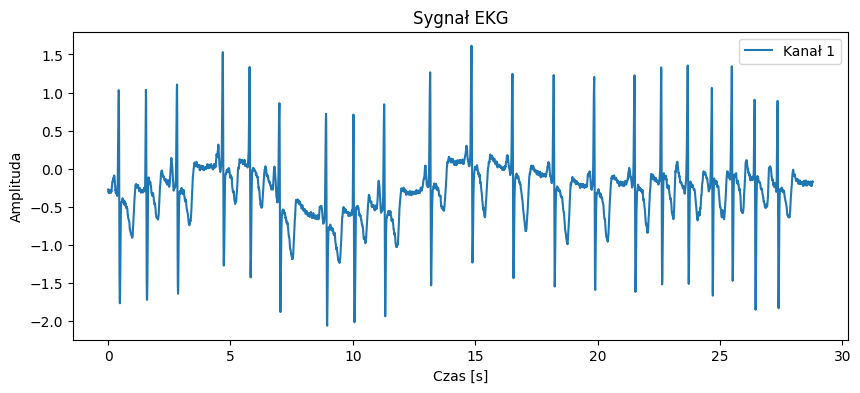

Indeksy przedziałów migotania przedsionków:
Start: 51292, Koniec: 59801
Start: 60886, Koniec: 61096
Start: 66674, Koniec: 83427
Start: 548122, Koniec: 549026
Start: 567648, Koniec: 569796
Start: 711218, Koniec: 711773
Start: 729638, Koniec: 730207


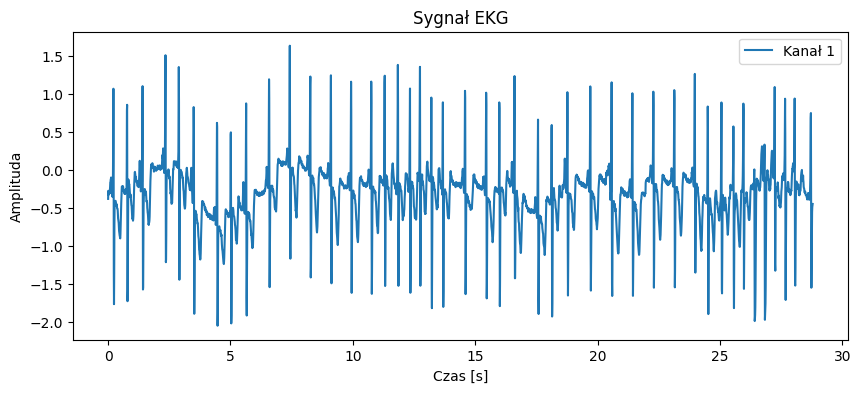

In [56]:
import numpy as np

# Ścieżka do pliku .npy z wektorem migotania przedsionków
file_path_list = ['../data/processed/afdb/04015_channel0.npy', '../data/processed/afdb/04015_ch0_sampl125Hz.npy']
for file_path in file_path_list:
    # Wczytaj plik .npy
    loaded_vectors = np.load(file_path)
    vector1_loaded = loaded_vectors[:, 0]
    afib_vector = loaded_vectors[:, 1]
    # Znajdź przedziały, gdzie wartość wynosi 1 (migotanie przedsionków)
    afib_intervals = []
    in_interval = False
    start_index = None

    for i, value in enumerate(afib_vector):
        if value == 1 and not in_interval:
            # Rozpoczęcie nowego przedziału
            start_index = i
            in_interval = True
        elif value == 0 and in_interval:
            # Koniec przedziału
            afib_intervals.append((start_index, i - 1))
            in_interval = False

    # Dodaj ostatni przedział, jeśli wektor kończy się jedynką
    if in_interval:
        afib_intervals.append((start_index, len(afib_vector) - 1))

    # Wyświetl wyniki
    print("Indeksy przedziałów migotania przedsionków:")
    for interval in afib_intervals:
        print(f"Start: {interval[0]}, Koniec: {interval[1]}")

    time = [i / sampling_rate for i in range(len(vector1_loaded))]  # Oś czasu
    plt.figure(figsize=(10, 4))
    plt.plot(time[:3600], vector1_loaded[:3600], label="Kanał 1")  # Pierwszy kanał0
    plt.xlabel('Czas [s]')
    plt.ylabel('Amplituda')
    plt.title('Sygnał EKG')
    plt.legend()
    plt.show()